In [297]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [340]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy

In [341]:
class ProcessData:
    def __init__(self, path, obj_name, obj_number):
        self.path = path
        self.obj_name = obj_name
        self.obj_number = obj_number
        self.WINDOW_SIZE = 4
        
        # prepare file names
        fpath_bio  = self.path + self.obj_name + '/' + self.obj_name + '_' + str(self.obj_number) + '_bio.csv'
        # read files
        df_bio = pd.read_csv(fpath_bio, index_col=False)
        df_bio.timestamp = df_bio.timestamp - df_bio.timestamp[0]
        df_bio_temp = df_bio[ (df_bio.timestamp >= 1) & (df_bio.timestamp <= 1+self.WINDOW_SIZE) ]
        # impute if small data
        if df_bio_temp.shape[0] == 399:
            df_bio_temp = df_bio_temp.append(df_bio.iloc[df_bio_temp.index[-1] + 1])
        self.df_bio = df_bio_temp
    def get_electrode_data(self):
        elctrd_cols = []
        for i in range(1,20):
            elctrd_cols.append('ele' + str(i))
        return self.df_bio[elctrd_cols].values
    def get_pac_data(self):
        pac_vals = []
        for i in range(1,23):
            pac_vals.append('pac' + str(i))
            
        count = 0
        pac_values = np.zeros(self.WINDOW_SIZE*100*22)
        for ind in self.df_bio[pac_vals].index:
            pac_values[count:count+22] = self.df_bio.loc[ind, pac_vals].values
            count += 22
        return pac_values
    def get_timestamp(self):
        return self.df_bio.timestamp.values

In [386]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 100, # 10
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 8800, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 8800,
            },
            "tgtSpikeCount": {True: 5000, False: 200},
        }
    },
}


In [387]:
device = torch.device('cuda:1')
slayer = snn.layer(params['neuron'], params['simulation'])
slayer = slayer.to(device)

In [388]:
# model_parameters = filter(lambda p: p.requires_grad, net.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])

In [389]:
fpath = '../material_data_Feb/'
mat_obj1 = ProcessData(fpath ,'mat15', 1)
sample = torch.FloatTensor(mat_obj1.get_pac_data().astype(float)).to(device)

In [390]:
sample = sample.reshape([1,1,1,1,8800])

In [391]:
sample_event = slayer.spike(sample)

In [392]:
torch.unique(sample_event)

tensor([0., 1.], device='cuda:1')

In [393]:
def plot_spike_train(spt,ax):
    st = copy.deepcopy(spt)
    st = st.reshape(st.shape[1], st.shape[4])
    for i, neuron in enumerate(st):
        for j, ts in enumerate(neuron):
            if st[i,j] == 1:
                st[i,j] = j
    st = st.tolist()
    for i, neuron in enumerate(st):
        st[i] = list(filter(lambda v: v != 0, neuron))
    ax.eventplot(st)
    ax.set_xlabel('Time Bin')
    ax.set_ylabel('Neuron')

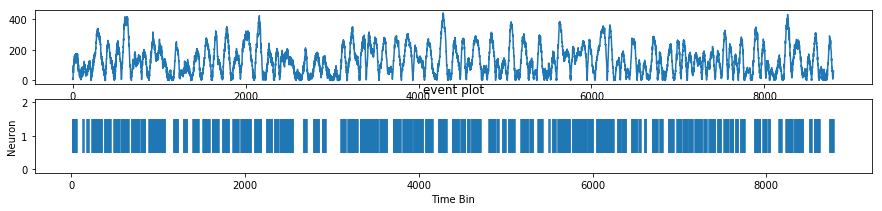

In [394]:
fig, ax = plt.subplots(2, figsize=(15,3))
ax[0].plot(mat_obj1.get_pac_data())
ax[1].set_title('event plot')
plot_spike_train(sample_event, ax[1])
plt.show()

In [395]:
torch.unique(sample_event)

tensor([0., 1.], device='cuda:1')

In [396]:
np.sum(sample_event.cpu().numpy().squeeze().astype(int))

1537